In [1]:
import types
import pandas as pd
import seaborn as sns
from botocore.client import Config
import ibm_boto3
import matplotlib.pyplot as plt
import pylab as pl
import numpy as np
%matplotlib inline

In [2]:
df = pd.read_csv('phone_reimbursments_OMN.csv')
df.head()

,MANAGER,PRACTITIONER,MONTH,AMOUNT,LOB
0,0,0,11,29.0,MARKETING
1,0,0,10,29.0,MARKETING
2,0,0,12,28.0,MARKETING
3,0,1,1,19.0,PFS
4,0,1,2,19.0,PFS


## Showing the data types in the dataframe df

In [6]:
df.dtypes

MANAGER           int64
PRACTITIONER      int64
MONTH             int64
AMOUNT          float64
LOB              object
dtype: object

The dataframe contains 591 records. The average claimed amount is around 38 INR

### Inferential statistical testing

In [7]:
df.describe()

,MANAGER,PRACTITIONER,MONTH,AMOUNT
count,591.000000,591.000000,591.000000,591.000000
mean,0.179357,0.389171,6.084602,37.700623
std,0.383976,0.487975,3.385855,28.238504
min,0.000000,0.000000,1.000000,2.620000
25%,0.000000,0.000000,3.000000,21.615000
50%,0.000000,0.000000,6.000000,29.852000
75%,0.000000,1.000000,9.000000,43.732000
max,1.000000,1.000000,12.000000,176.742667


In [21]:
df.groupby('MONTH').sum()

,MANAGER,PRACTITIONER,AMOUNT
MONTH,,,
1,10,23,2077.154000
2,10,19,2156.058000
3,11,18,2221.328000
4,12,20,2232.757000
5,10,19,2088.711000
6,10,18,1910.392000
7,8,19,1904.683667
8,8,19,1669.493667
9,8,18,1533.367667


### The histogram shows that most of the claimed amounts are between 15 and 35 INR. There are a couple of outliers in the range of >100 INR

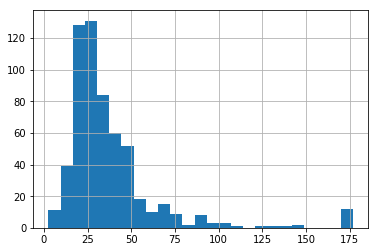

In [50]:
hist = df['AMOUNT'].hist(bins=25)

### Showing the distribution of claims for non-managers and managers respectively

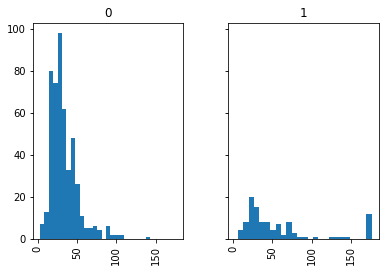

In [3]:
hist = df.hist(by='MANAGER', column='AMOUNT', bins=25, sharey=True, sharex=True)

In [4]:
df.groupby('MANAGER')['AMOUNT'].count()

MANAGER
0    485
1    106
Name: AMOUNT, dtype: int64

In [5]:
df.groupby('PRACTITIONER')['AMOUNT'].count()

PRACTITIONER
0    361
1    230
Name: AMOUNT, dtype: int64

## Showing the average expense claim amount grouped by MANAGER and then by PRACTITIONER. We will use it to compare the result of the clustering with this basic approach later

In [37]:
df.groupby(['MANAGER', 'PRACTITIONER'])['AMOUNT'].mean()

MANAGER  PRACTITIONER
0        0               35.791790
         1               29.901615
1        0               63.384628
         1               20.662750
Name: AMOUNT, dtype: float64

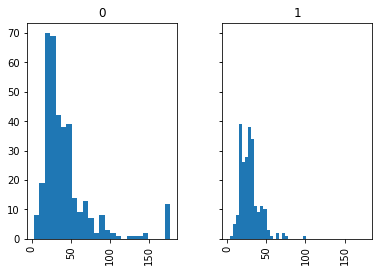

In [6]:
hist = df.hist(by='PRACTITIONER', column='AMOUNT', bins=25, sharey=True, sharex=True)

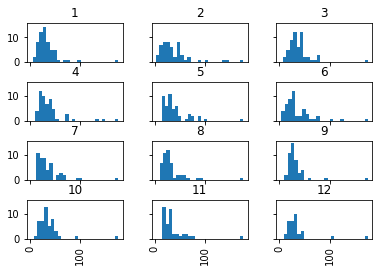

In [3]:
hist = df.hist(by='MONTH', column='AMOUNT', bins=25, sharey=True, sharex=True)

## Let us check the probability density for each month's amount (I have grouped them to quarters). In certain cases this is a better representation than the histogram for the distribusion of amounts.

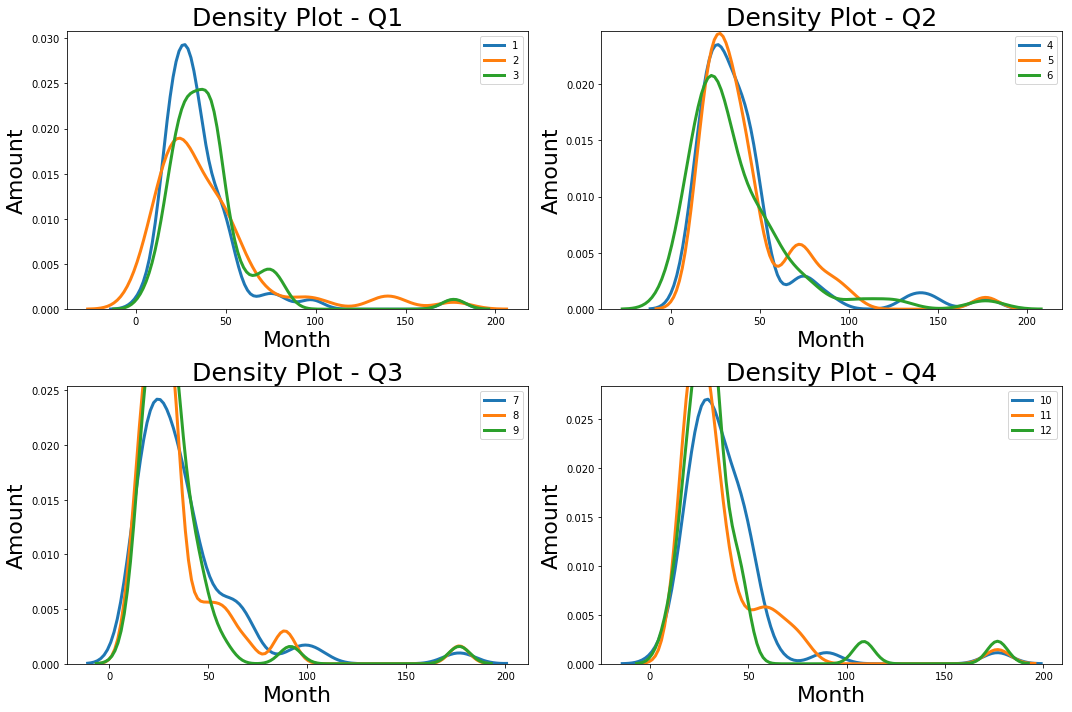

In [28]:
months = df['MONTH'].unique().tolist()
quarters = [[1,2,3],[4, 5, 6],[7,8,9],[10,11,12]]

fig = plt.figure(figsize = (15,10))
ax = fig.gca()

for i, quarter in enumerate(quarters):
    
    # Set up the plot
    ax = plt.subplot(2, 2, i + 1)
    
    for month in quarter:
        subset = df[df['MONTH'] == month]
        
        sns.distplot(subset['AMOUNT'], hist = False, kde = True,
                     kde_kws = {'linewidth': 3},
                     label = month,
                     ax=ax)
        
        ax.set_title('Density Plot - Q%d' % (i+1), size = 25)
        ax.set_xlabel('Month', size = 22)
        ax.set_ylabel('Amount', size= 22)

plt.tight_layout()
plt.show()

### Series of Box plots showing the distribution of the monthly expense claims. Looks like that all months are more or less the same in terms of the median. In each month we have a number of outliers.

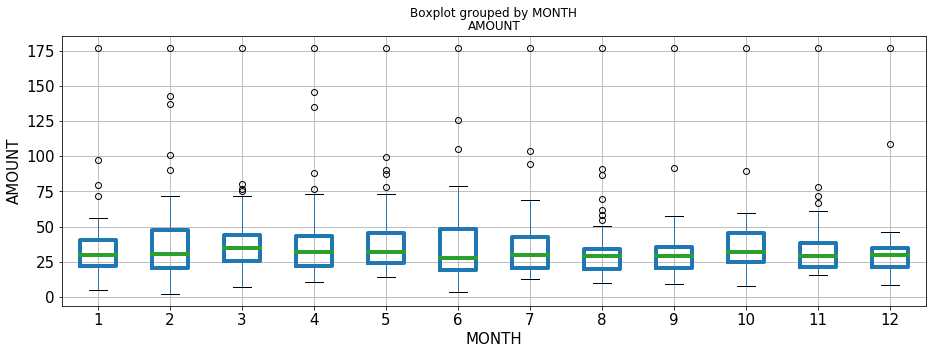

In [7]:
fig = plt.figure(figsize = (15,5))
plt.xlabel('MONTH', size = 15)
plt.ylabel('AMOUNT', size = 15)
plt.title('BOXPLOT - INVOICE AMOUNT GROUPED BY MONTH', size = 40)
plt.xticks(size = 15)
plt.yticks(size = 15)
ax = fig.gca()
boxprops = dict(linestyle='-', linewidth=4, color='k')
medianprops = dict(linestyle='-', linewidth=4, color='k')
hist = df.boxplot(by='MONTH', column='AMOUNT', ax=ax, boxprops=boxprops, medianprops=medianprops)
plt.show()

### A similar Box plot series is showing the amounts by LOBs. The MARKETING and the SECURITY SOLUTIONS department are claiming more than the others.

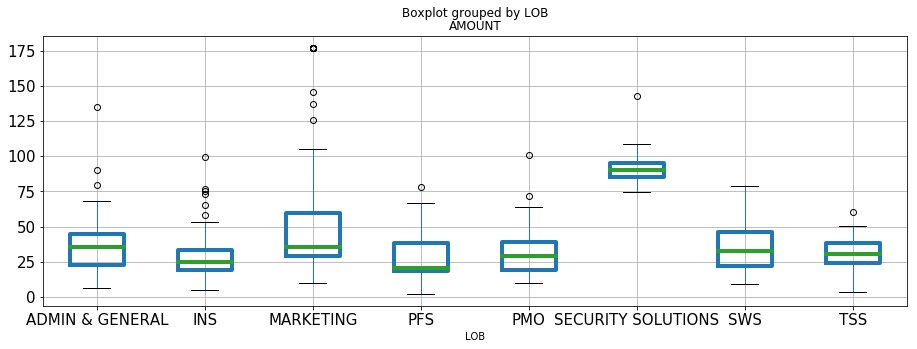

In [8]:
fig = plt.figure(figsize = (15,5))
plt.xticks(size = 15)
plt.yticks(size = 15)
ax = fig.gca()
boxprops = dict(linestyle='-', linewidth=4, color='k')
medianprops = dict(linestyle='-', linewidth=4, color='k')
hist = df.boxplot(by='LOB', column='AMOUNT', ax=ax, boxprops=boxprops, medianprops=medianprops)

#### Let us narrow down our inferential statistical focus to the MANAGER and PRACTITIONER features. The following Box plots are showing how the expense claims are distributed between non-managers and managers and also non-practitioners and practitioners. Managers seems to claim more expense.

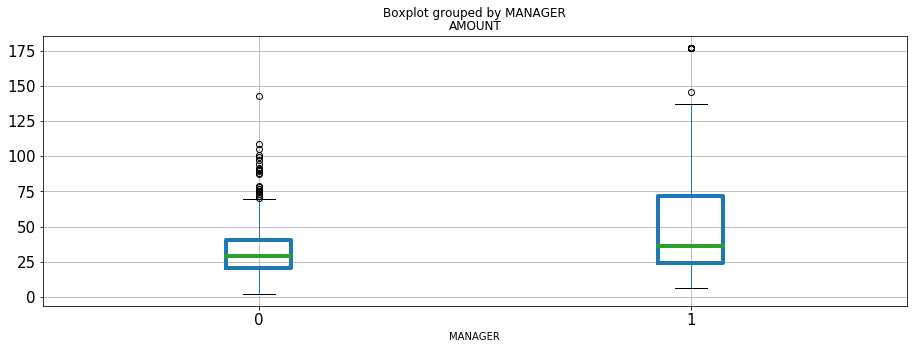

In [9]:
fig = plt.figure(figsize = (15,5))
plt.xticks(size = 15)
plt.yticks(size = 15)
ax = fig.gca()
boxprops = dict(linestyle='-', linewidth=4, color='k')
medianprops = dict(linestyle='-', linewidth=4, color='k')
hist = df.boxplot(by='MANAGER', column='AMOUNT', ax=ax, boxprops=boxprops, medianprops=medianprops)

#### There is no significant difference between non-practitioners and practitioners in terms of expense claims.

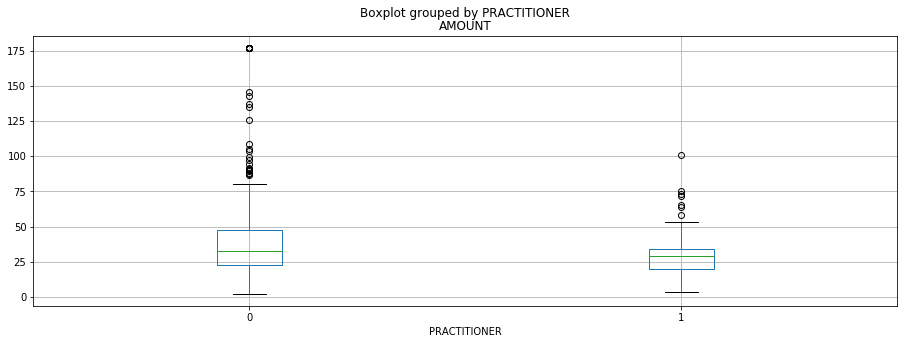

In [12]:
fig = plt.figure(figsize = (15,5))
ax = fig.gca()
hist = df.boxplot(by='PRACTITIONER', column='AMOUNT', ax=ax)

#### Plot the distribution for each LOB on a histogram. MARKETING and INS seems to contribute the most to the expenses.

/opt/conda/envs/DSX-Python35/lib/python3.5/site-packages/pandas/plotting/_core.py:2164: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  yrot=yrot, **kwds)


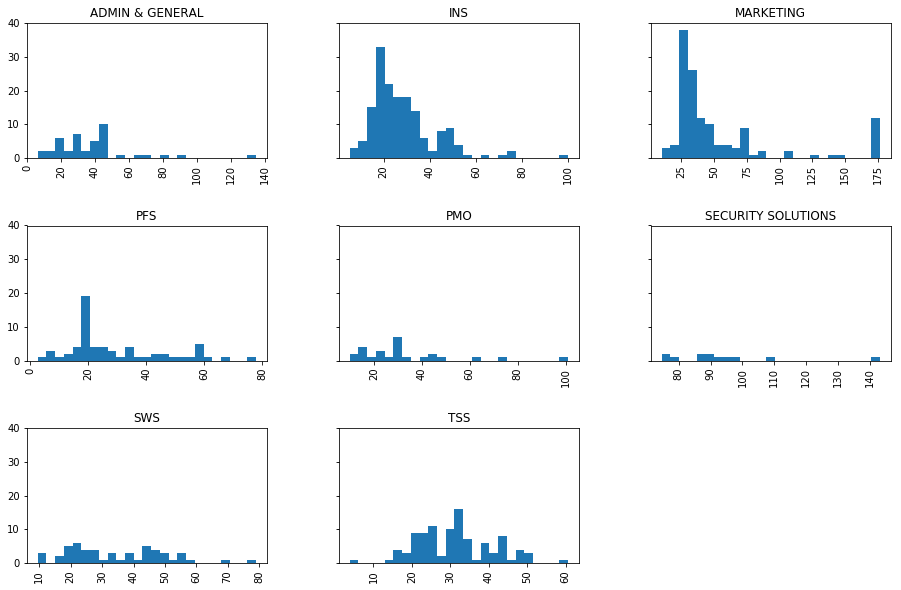

In [17]:
fig = plt.figure(figsize = (15,10))
ax = fig.gca()
hist = df.hist(by='LOB', column='AMOUNT', bins=25, sharey=True, ax=ax)

In [21]:
df.groupby(['LOB'])['AMOUNT'].sum()

LOB
ADMIN & GENERAL       1606.501
INS                   4655.768
MARKETING             7288.927
PFS                   1839.722
PMO                    853.053
SECURITY SOLUTIONS    1120.567
SWS                   1805.577
TSS                   3110.953
Name: AMOUNT, dtype: float64

## Regression testing

###### Changing categorical variable LOB with one hot encoding so it can be used for further analysis

In [23]:
Feature = df
Feature = pd.concat([Feature,pd.get_dummies(df['LOB'])], axis=1)
del Feature['LOB']
# Feature.head()
Feature.describe()

,MANAGER,PRACTITIONER,MONTH,AMOUNT,ADMIN & GENERAL,INS,MARKETING,PFS,PMO,SECURITY SOLUTIONS,SWS,TSS
count,591.000000,591.000000,591.000000,591.000000,591.000000,591.000000,591.000000,591.000000,591.000000,591.000000,591.000000,591.000000
mean,0.179357,0.389171,6.084602,37.700623,0.071066,0.275804,0.225042,0.106599,0.043993,0.020305,0.087986,0.169205
std,0.383976,0.487975,3.385855,28.238504,0.257153,0.447297,0.417964,0.308864,0.205254,0.141160,0.283515,0.375250
min,0.000000,0.000000,1.000000,2.620000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,3.000000,21.615000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,6.000000,29.852000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,1.000000,9.000000,43.732000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,12.000000,176.742667,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [6]:
Feature.groupby('MONTH').sum()

,MANAGER,PRACTITIONER,AMOUNT,ADMIN & GENERAL,INS,MARKETING,PFS,PMO,SECURITY SOLUTIONS,SWS,TSS
MONTH,,,,,,,,,,,
1,10,23,2077.154000,4,15,11,10,2,1,4,12
2,10,19,2156.058000,4,13,12,8,2,1,3,10
3,11,18,2221.328000,4,15,12,8,2,1,5,9
4,12,20,2232.757000,4,16,14,5,2,1,5,8
5,10,19,2088.711000,3,14,13,5,2,1,5,7
6,10,18,1910.392000,4,12,14,6,2,1,5,7
7,8,19,1904.683667,5,14,11,6,2,1,4,7
8,8,19,1669.493667,4,14,10,5,2,1,5,7
9,8,18,1533.367667,2,14,10,3,2,1,6,8


Create a train and a test data set randomly (80% is used for training). The predictors are added to a list so later I can check all of them separately in their relation to the target variable (AMOUNT).

In [24]:
msk = np.random.rand(len(df)) < 0.8
train = Feature[msk]
test = Feature[~msk]
predictors = ['ADMIN & GENERAL', 'INS', 'MARKETING', 'PFS', 'PMO', 'SECURITY SOLUTIONS', 'SWS', 'TSS']
# predictors = ['MANAGER', 'PRACTITIONER', 'MONTH']
target = ['AMOUNT']

Let us check whether there is any relation between the predictors and the target variable of AMOUNT

In [25]:
from sklearn import linear_model
regr = linear_model.LinearRegression()
x = np.asanyarray(train[predictors])
y = np.asanyarray(train[target])
regr.fit (x, y)
# The coefficients
print ('Coefficients: ', regr.coef_)

Coefficients:  [[ -5.49255699 -13.93919756  13.1019838  -13.41759373  -8.33523318
   46.39532237  -7.26554985 -11.04717485]]


In [26]:
y_hat= regr.predict(test[predictors])
x = np.asanyarray(test[predictors])
y = np.asanyarray(test[target])
print("Residual sum of squares: %.2f"
      % np.mean((y_hat - y) ** 2))

# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % regr.score(x, y))

Residual sum of squares: 508.01
Variance score: 0.28


Now let us loop through each predictor and add PRACTITIONER to this list to see whether they are related to the target variable or not

In [27]:
for i in range(len(predictors)):
    regr = linear_model.LinearRegression()
    x = np.asanyarray(train[predictors[i:i+1] + ['PRACTITIONER']])
    # x = np.asanyarray(train[predictors[i:i+1]])
    y = np.asanyarray(train[target])
    regr.fit (x, y)
    # The coefficients
    print ('Coefficients: ', regr.coef_, 'for predictor', predictors[i])
    
    y_hat= regr.predict(test[predictors[i:i+1] + ['PRACTITIONER']])
    x = np.asanyarray(test[predictors[i:i+1] + ['PRACTITIONER']])
    # y_hat= regr.predict(test[predictors[i:i+1]])
    # x = np.asanyarray(test[predictors[i:i+1]])
    y = np.asanyarray(test[target])
    print("Residual sum of squares: %.2f"
      % np.mean((y_hat - y) ** 2))

    # Explained variance score: 1 is perfect prediction
    print('Variance score: %.2f' % regr.score(x, y))

Coefficients:  [[ -6.90231181 -14.20009553]] for predictor ADMIN & GENERAL
Residual sum of squares: 659.88
Variance score: 0.06
Coefficients:  [[ -8.09930811 -10.23877031]] for predictor INS
Residual sum of squares: 650.10
Variance score: 0.08
Coefficients:  [[ 19.96573281  -5.9265917 ]] for predictor MARKETING
Residual sum of squares: 632.48
Variance score: 0.10
Coefficients:  [[-13.90313827 -14.87809035]] for predictor PFS
Residual sum of squares: 635.89
Variance score: 0.10
Coefficients:  [[  5.02212121 -13.91945689]] for predictor PMO
Residual sum of squares: 657.15
Variance score: 0.07
Coefficients:  [[ 47.3277814  -11.85788168]] for predictor SECURITY SOLUTIONS
Residual sum of squares: 557.97
Variance score: 0.21
Coefficients:  [[ -5.33076313 -13.67434044]] for predictor SWS
Residual sum of squares: 651.74
Variance score: 0.07
Coefficients:  [[ -3.3528341  -12.68491234]] for predictor TSS
Residual sum of squares: 652.55
Variance score: 0.07


Since the variance score is very clost to 0.0 (or even a negative number depending on the train set) we can conclude that there is no linear relationship between the predictors and the target variable.

## Clustering with K-Means

In [33]:
phone_df = Feature
phone_df.head()

,MANAGER,PRACTITIONER,MONTH,AMOUNT,ADMIN & GENERAL,INS,MARKETING,PFS,PMO,SECURITY SOLUTIONS,SWS,TSS
0,0,0,11,29.0,0,0,1,0,0,0,0,0
1,0,0,10,29.0,0,0,1,0,0,0,0,0
2,0,0,12,28.0,0,0,1,0,0,0,0,0
3,0,1,1,19.0,0,0,0,1,0,0,0,0
4,0,1,2,19.0,0,0,0,1,0,0,0,0


Scale our variables in the data frame so they will fit better for the purpose of K-Means

In [34]:
X = phone_df.values
X = np.nan_to_num(X)
phone_dataSet = StandardScaler().fit_transform(X)
phone_dataSet

array([[-0.46750048, -0.79819742,  1.45297447, ..., -0.14396315,
        -0.31060418, -0.45129368],
       [-0.46750048, -0.79819742,  1.15737795, ..., -0.14396315,
        -0.31060418, -0.45129368],
       [-0.46750048, -0.79819742,  1.748571  , ..., -0.14396315,
        -0.31060418, -0.45129368],
       ..., 
       [-0.46750048,  1.2528229 ,  0.86178142, ..., -0.14396315,
        -0.31060418,  2.21585198],
       [-0.46750048,  1.2528229 ,  1.15737795, ..., -0.14396315,
        -0.31060418,  2.21585198],
       [-0.46750048,  1.2528229 ,  1.45297447, ..., -0.14396315,
        -0.31060418,  2.21585198]])

In [30]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

In [35]:
Sum_of_squared_distances = []
K = range(1,15)
for k in K:
    km = KMeans(init = "k-means++", n_clusters=k, n_init=12)
    km = km.fit(phone_dataSet)
    Sum_of_squared_distances.append(km.inertia_)

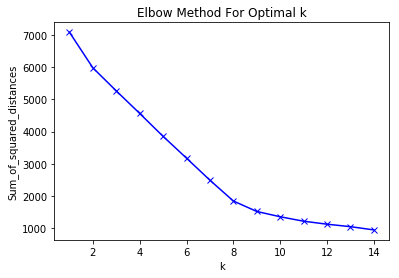

In [36]:
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

It seems that the elbow point is at k=8. I will also test k=2 since there is a significant drop in the sum of square roots between k=1 and k=2 as well.

In [38]:
clusterNum = 8
k_means_phone = KMeans(init = "k-means++", n_clusters = clusterNum, n_init = 12)
k_means_phone.fit(phone_dataSet)
labels_phone = k_means_phone.labels_
labels_phone

array([3, 3, 3, 5, 5, 5, 5, 5, 5, 5, 5, 4, 4, 4, 4, 4, 4, 4, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0,
       0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3,

In [39]:
phone_df["Phone_km"] = labels_phone
phone_df.head()

,MANAGER,PRACTITIONER,MONTH,AMOUNT,ADMIN & GENERAL,INS,MARKETING,PFS,PMO,SECURITY SOLUTIONS,SWS,TSS,Phone_km
0,0,0,11,29.0,0,0,1,0,0,0,0,0,3
1,0,0,10,29.0,0,0,1,0,0,0,0,0,3
2,0,0,12,28.0,0,0,1,0,0,0,0,0,3
3,0,1,1,19.0,0,0,0,1,0,0,0,0,5
4,0,1,2,19.0,0,0,0,1,0,0,0,0,5


In [40]:
phone_df.groupby(["Phone_km"]).mean()

,MANAGER,PRACTITIONER,MONTH,AMOUNT,ADMIN & GENERAL,INS,MARKETING,PFS,PMO,SECURITY SOLUTIONS,SWS,TSS
Phone_km,,,,,,,,,,,,
0,0.461538,1.000000,6.884615,32.809731,0,0,0,0,1,0,0,0
1,0.000000,0.723926,6.257669,28.562994,0,1,0,0,0,0,0,0
2,0.120000,0.660000,6.180000,31.109530,0,0,0,0,0,0,0,1
3,0.360902,0.000000,6.052632,54.803962,0,0,1,0,0,0,0,0
4,0.153846,0.230769,6.307692,34.722635,0,0,0,0,0,0,1,0
5,0.142857,0.126984,5.000000,29.201937,0,0,0,1,0,0,0,0
6,0.404762,0.000000,6.023810,38.250024,1,0,0,0,0,0,0,0
7,0.000000,0.000000,6.500000,93.380583,0,0,0,0,0,1,0,0


It seems that the clustering algorithm has created a cluster for each LOB.

Now let see what would be the result if we change k=2.

In [41]:
clusterNum = 2
k_means_phone = KMeans(init = "k-means++", n_clusters = clusterNum, n_init = 12)
k_means_phone.fit(phone_dataSet)
labels_phone = k_means_phone.labels_
phone_df["Phone_km"] = labels_phone

In [43]:
phone_df.groupby(['Phone_km']).mean()

,MANAGER,PRACTITIONER,MONTH,AMOUNT,ADMIN & GENERAL,INS,MARKETING,PFS,PMO,SECURITY SOLUTIONS,SWS,TSS
Phone_km,,,,,,,,,,,,
0,0.319728,0.000000,5.928571,45.899704,0.142857,0.000000,0.452381,0.187075,0.000000,0.040816,0.136054,0.040816
1,0.040404,0.774411,6.239057,29.584360,0.000000,0.548822,0.000000,0.026936,0.087542,0.000000,0.040404,0.296296


After re-running the K-Means algorith we can clearly differentiate 2 major groups:
1. the first cluster is for <b> managers and non-practitioners </b> (roughly 46 INR / month) and 
2. the second cluster is for <b> non-managers and practitioners </b> (roughly 30 INR / month).

Let see how our clusters are looking like on a color coded histogram.

Phone_km
0    AxesSubplot(0.125,0.125;0.775x0.755)
1    AxesSubplot(0.125,0.125;0.775x0.755)
Name: AMOUNT, dtype: object

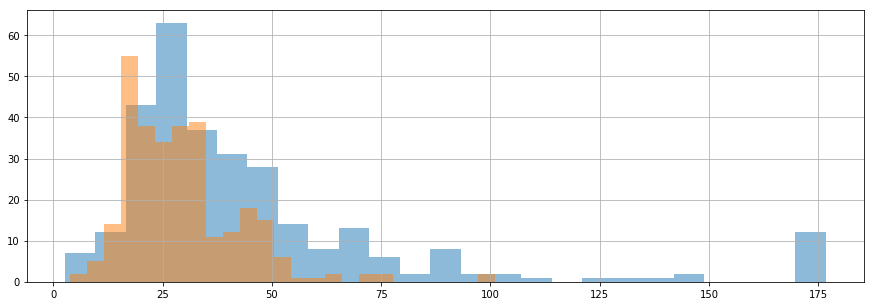

In [44]:
fig = plt.figure(figsize = (15,5))
ax = fig.gca()
phone_df.groupby('Phone_km').AMOUNT.hist(alpha=0.5, ax=ax, bins=25)